# OneClassSVM - Train model on ASTRO data 3 FEATURES + predict on UNIDs

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from mpl_toolkits.mplot3d import Axes3D

In [231]:
# --- Cargar dataset ---
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep=r"\s+")

# Renombramos la columna target por claridad
df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})

# --- Comprobamos distribución del dataset ---
print(f"📁 Dataset loaded. Shape: {df_astro.shape}")
print(f"🧠 Column names: {list(df_astro.columns)}")

# --- Selección de características ---
features = ['E_peak', 'beta', 'sigma']
target = 'class'

print(f"✅ Selected features: {features}")
print(f"🎯 Target column: {target}")

# --- Comprobamos valores nulos ---
print("\n🔍 Missing values per column:")
print(df_astro[features + [target]].isnull().sum())

print("\n📌 Sample of the dataset:")
display(df_astro[features + [target]].head())


📁 Dataset loaded. Shape: (2831, 5)
🧠 Column names: ['E_peak', 'beta', 'sigma', 'beta_Rel', 'class']
✅ Selected features: ['E_peak', 'beta', 'sigma']
🎯 Target column: class

🔍 Missing values per column:
E_peak    0
beta      0
sigma     0
class     0
dtype: int64

📌 Sample of the dataset:


,E_peak,beta,sigma,class
0,-0.412502,-1.325139,1.356951,0.0
1,0.708140,-0.000174,0.623167,0.0
2,0.224740,-0.581202,1.010041,0.0
3,0.257319,-0.561933,0.615413,0.0
4,0.326110,-1.100179,1.624932,0.0


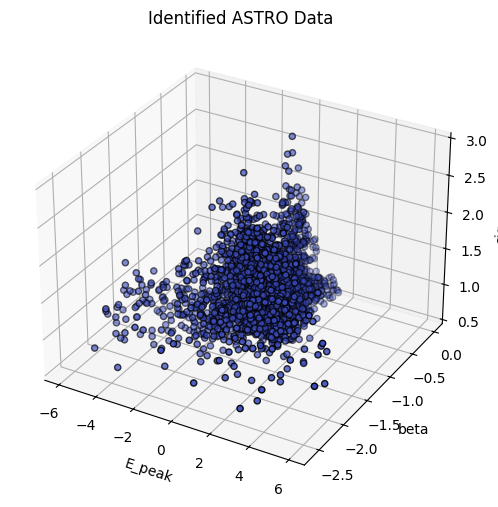

In [232]:
# Select 3 features
x = df_astro['E_peak']
y = df_astro['beta']
z = df_astro['sigma']

# Optional: use class if available to color the points
labels = df_astro['class']

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=labels, cmap='coolwarm', edgecolor='k')

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma')
plt.title('Identified ASTRO Data')
plt.show()


In [233]:
# Seleccionamos las features dinámicamente
X = df_astro[features].values
y = df_astro["class"].values

# Split: Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [234]:
# Filtrar solo clase 0 para entrenar One-Class SVM
X_train_scaled = X_train_scaled[y_train == 0]
y_train = y_train[y_train == 0]

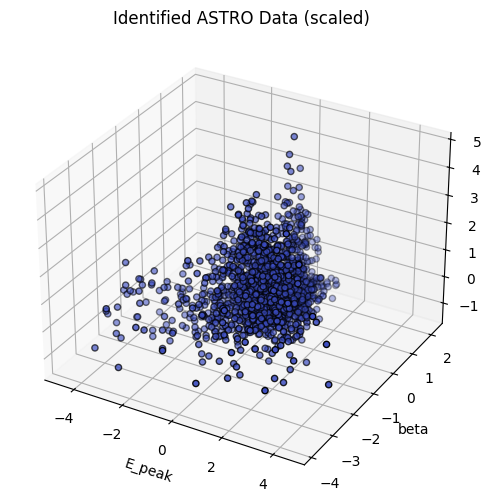

In [235]:
# Comprobamos los datos escalados
x = X_train_scaled[:, 0]
y = X_train_scaled[:, 1]
z = X_train_scaled[:, 2]

# Scatter plot 3D de X_train_scaled
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=y_train, cmap='coolwarm', edgecolor='k')
ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma')
plt.title('Identified ASTRO Data (scaled)')
plt.show()


# Entenar modelo + Validación

In [236]:
# OPTIMIZACION BASADA EN PUNTUACION F1 PARA DATOS ETIQUETADOS 

# --- Hiperparámetros a explorar ---
nu_values = [0.005, 0.01, 0.02, 0.05]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

# --- Tracking de resultados ---
results = []
best_score = 0.0  # F1 score (cuanto más alto, mejor)
best_model = None
best_params = {}

# --- Grid Search ---
print("🔍 Iniciando búsqueda de hiperparámetros basada en F1-score...\n")
for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        # Predicciones
        preds = model.predict(X_val_scaled)              # 1 = inlier, -1 = outlier
        pred_labels = np.where(preds == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int

        # Evaluación
        f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'f1_score': f1})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# --- Resultados Finales ---
print("✅ Mejor combinación de hiperparámetros:")
print(f"   - nu = {best_params['nu']}")
print(f"   - gamma = {best_params['gamma']}")
print(f"📈 Mejor F1-Score en validación: {best_score:.4f}")

# --- Convertimos resultados en DataFrame (opcional) ---
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='f1_score', ascending=False))

🔍 Iniciando búsqueda de hiperparámetros basada en F1-score...

✅ Mejor combinación de hiperparámetros:
   - nu = 0.005
   - gamma = 0.001
📈 Mejor F1-Score en validación: 0.9965


,nu,gamma,f1_score
2,0.005,0.001,0.996454
3,0.005,0.01,0.995563
4,0.005,0.1,0.995563
9,0.010,0.001,0.992883
10,0.010,0.01,0.992883
11,0.010,0.1,0.991986
16,0.020,0.001,0.985663
17,0.020,0.01,0.985663
14,0.020,scale,0.983842
15,0.020,auto,0.983842


In [237]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model = OneClassSVM(kernel='rbf', nu=best_params['nu'], gamma=best_params['gamma'])
best_model.fit(X_train_scaled)

OneClassSVM(gamma=np.float64(0.001), nu=0.005)

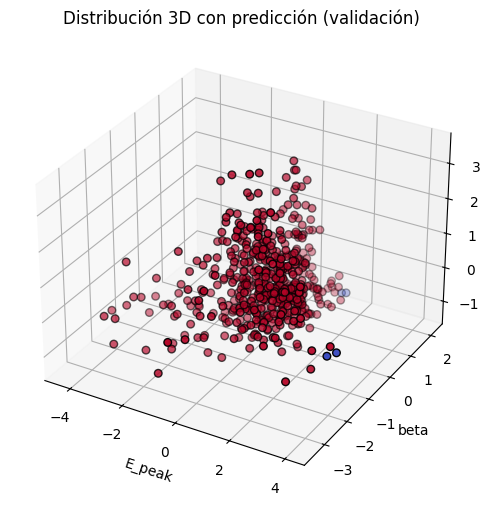

In [238]:
# Visualizamos predicciones en 3D sobre datos de validación
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

X_3d = X_val_scaled
preds = best_model.predict(X_3d)
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=preds, cmap='coolwarm', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (validación)")
plt.show()

### Doble comprobación con datos ASTRO reservados de prueba

In [239]:
# Evaluamos sobre los datos de prueba con el mejor modelo ya entrenado
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)

print(f"Outliers en conjunto de datos de prueba: {n_test_outliers}")
test_labels = np.where(test_preds == 1, 0, 1)  # 1 = normal, -1 = outlier → mapeado
true_labels_test = y_test.astype(int)

print("\n📉 Matriz de confusión (Test Set):")
print(confusion_matrix(true_labels_test, test_labels))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=["Normal", "Anomalía"], zero_division=1))

Outliers en conjunto de datos de prueba: 5

📉 Matriz de confusión (Test Set):
[[562   5]
 [  0   0]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       567
    Anomalía       0.00      1.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      1.00      0.50       567
weighted avg       1.00      0.99      1.00       567



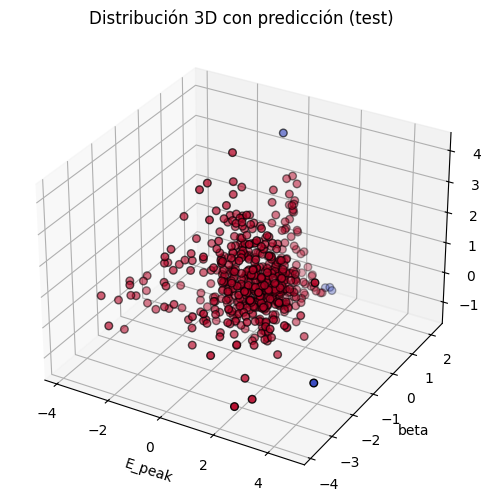

In [240]:
# Visualizamos predicciones en 3D sobre datos de prueba
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

X_3d = X_test_scaled
preds = best_model.predict(X_3d)
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=preds, cmap='coolwarm', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (test)")
plt.show()